## Voting Classifier (meta estimator)

In [3]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification


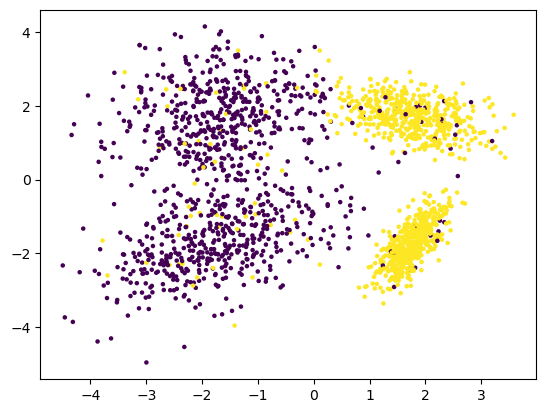

In [19]:
X, y = make_classification(n_samples=2000, n_features=2,
                          n_redundant=0, random_state=21,
                          class_sep=1.75, flip_y=0.1)
# plt.figure(figsize=(9,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s = 5);

voting classifier balances the estimators(different models)

to get pretty plots:

In [20]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

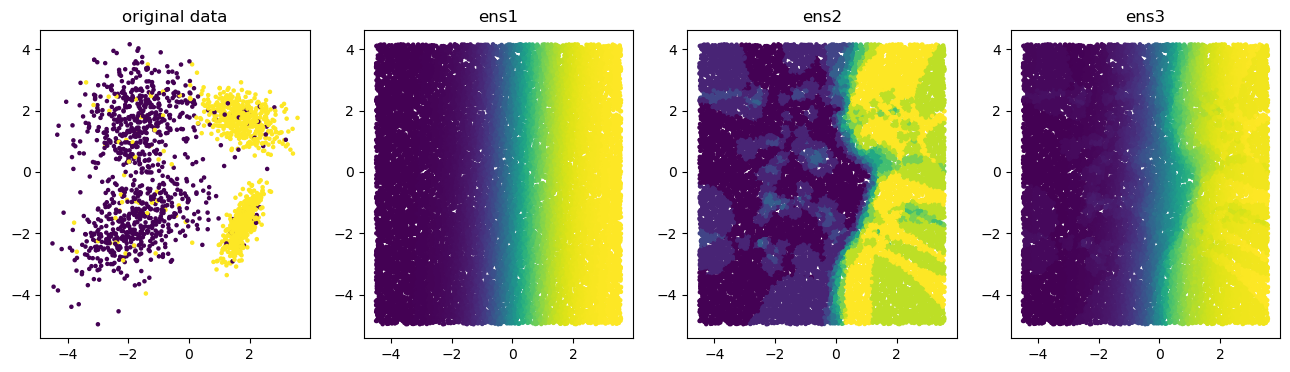

In [22]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft', # average the predict proba values
                        weights=[10.5, 2.5]) # weight of each estimator
clf3.fit(X, y)

make_plots()

## Threshold

In [25]:
%pip install scikit-lego

   ---------------------------------------- 0.0/216.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/216.7 kB ? eta -:--:--
   - -------------------------------------- 10.2/216.7 kB ? eta -:--:--
   ----- --------------------------------- 30.7/216.7 kB 262.6 kB/s eta 0:00:01
   ------- ------------------------------- 41.0/216.7 kB 281.8 kB/s eta 0:00:01
   -------------- ------------------------ 81.9/216.7 kB 416.7 kB/s eta 0:00:01
   ---------------- ---------------------- 92.2/216.7 kB 374.1 kB/s eta 0:00:01
   ------------------------------ ------- 174.1/216.7 kB 583.1 kB/s eta 0:00:01
   -------------------------------------- 216.7/216.7 kB 629.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/152.4 kB ? eta -:--:--
   -------------------------------- ------- 122.9/152.4 kB 7.0 MB/s eta 0:00:01
   -------------------------------- ------- 122.9/152.4 kB 7.0 MB/s eta 0:00:01
   -------------------------------- ------- 122.9/152.4 kB 7.0 MB/s eta 0:

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego.meta import Thresholder

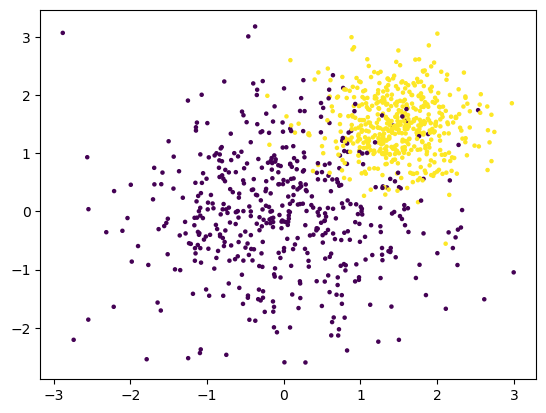

In [29]:
X, y = make_blobs(1000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

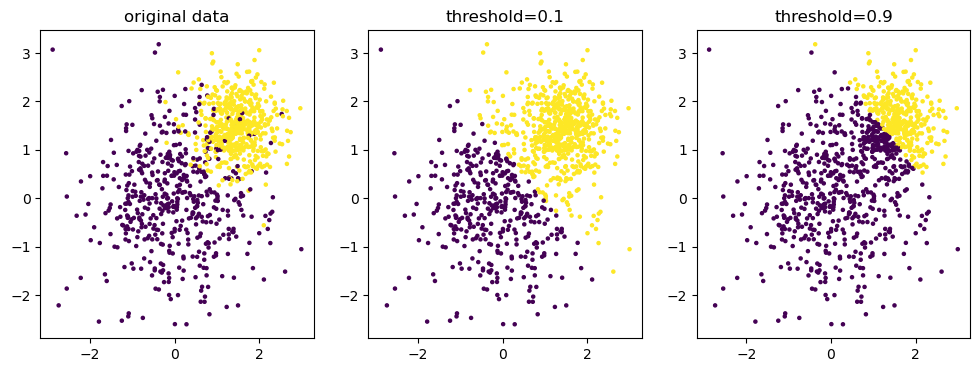

In [31]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X, y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X, y)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

at 0.1 may be good for recall but bad for precision, and at 0.9 is very a precision but very low recal

#### use this inside a grid search

In [53]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y);

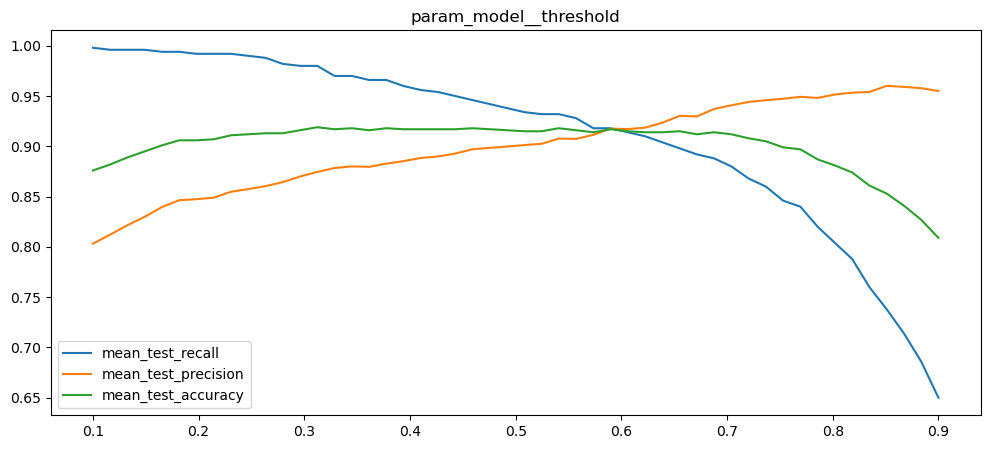

In [54]:
import pandas as pd
plt.figure(figsize=(12, 5))
df_results = pd.DataFrame(mod.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_accuracy']:
    plt.plot(df_results['param_model__threshold'],
            df_results[score],
            label=score)
plt.title("param_model__threshold")
plt.legend();

from this we can say threshold is an example of postprocessing because for this we need to have the model ready for us to assess these metrics and it is also easy to interpret. And these sorts of post processing are best implemented as meta models(models that accept other models as input)